# **Sec-Filings**

The dataset presented in this work combines the CoNLL-2003 data with financial documents sourced from U.S. Securities and Exchange Commission (SEC) filings.

The CoNLL-2003 dataset consists of eight text files annotated with named entities. The entities are divided into four main categories: persons, organizations, locations and miscellaneous entities. Each token in the dataset is labeled with its corresponding entity type, providing a labeled corpus for training and evaluating Named Entity Recognition (NER) model.

The dataset is divided into two subsets (*train* and *test* datasets) and each of them has four columns:

- `id` : tokens
- `chunk_label`: classification label for named entity
- `-`: empty column
- `ner_tags`: classification label for named entity

The `chunk_label` column contains for each token a fine-grained tag as determined by morphology (e.g., NNP for a singular proper noun, VBD for a past tense verbe, etc.).

There are five different types of `ner_tags` in the dataset:

<table><tr><th>NER</th><th>DESCRIPTION</th><th>EXAMPLES</th></tr>

<tr><td>O</td><td>Token that belongs to no chunk</td><td>loan, security, agreement</td></tr>
<tr><td>I-LOC</td><td>Token representing a location</td><td>California, Massachusetts</td></tr>
<tr><td>I-PER</td><td>Token representing a person</td><td>Bing, Yu</td></tr>
<tr><td>I-ORG</td><td>Token representin an organization</td><td>Silicon Valley Bank</td></tr>
<tr><td>I-MISC</td><td>Token with no specific category</td><td>Chinese, English</td></tr>

The aim of this paper is to build a model that is able to correctly predict the `ner_tag` of each token. Since the dataset already contains the appropriate tag, some supervised learning algorithms will be implemented. They receive a set of inputs along with the corresponding correct outputs and learn by comparing their actual outputs with the correct ones to find errors.


The training dataset, consisting of 42182 observations, is cleaned and prepared to be used in different tasks. An exploratory analysis is then performed and the key findings are then exhibited using data visualization techniques.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/FIN5.csv', sep = ';')
df.columns = ['id', 'chunk_label', 'empty', 'ner_tags']
df = df.drop(0)
df.head()

,id,chunk_label,empty,ner_tags
1,This,DT,-,O
2,LOAN,NN,-,O
3,AND,CC,-,O
4,SECURITY,NNP,-,O
5,AGREEMENT,NNP,-,O


The first five rows of the dataset are represented by way of example in the table above.

# Data preparation and cleaning

For consistency, ensure that all column labels are of type string.

In [ ]:
all(isinstance(column, str) for column in df.columns)

True

Once checked for the existence of missing values, 1167 observations are removed from the dataset.

In [ ]:
df.isnull().sum()

id             1167
chunk_label    1167
empty          1167
ner_tags       1167
dtype: int64

In [ ]:
df = df.dropna()

len(df)

41014

In [ ]:
df.isnull().sum()

id             0
chunk_label    0
empty          0
ner_tags       0
dtype: int64

Then, empty strings have been detected and removed, in order not to have blank cells.

In [ ]:
blanks = []

# (index,id,chunk_label,empty,ner_tags)
for index,id,chunk_label,empty,ner_tags in df.itertuples():  # iterate over the DataFrame
    if type(id)==str:                                        # avoid NaN values
        if id.isspace():                                     # test 'review' for whitespace
            blanks.append(index)                             # add matching index numbers to the list

blanks

[]

Empty columns are dropped as well.

In [ ]:
df.drop("empty", axis = 'columns', inplace = True)

df

,id,chunk_label,ner_tags
1,This,DT,O
2,LOAN,NN,O
3,AND,CC,O
4,SECURITY,NNP,O
5,AGREEMENT,NNP,O
...,...,...,...
42177,/,NN,O
42178,s,NNS,O
42179,/,:,O
42180,Bing,VBG,I-PER


The number of tokens corresponding to the 10 most frequent `chunk_label` is:







In [ ]:
df['chunk_label'].value_counts()[:10]

NNP    6067
NN     5617
IN     4772
DT     4215
NNS    2308
CC     2300
,      2075
JJ     1903
CD     1488
:      1400
Name: chunk_label, dtype: int64

As reasonably expected, the most frequent ones are those related to nouns, conjunctions, determiners and punctuation marks.

Instead, the frequency of the five `ner_tags` is:

In [ ]:
df['ner_tags'].value_counts()

O         39484
I-PER       783
I-ORG       384
I-LOC       356
I-MISC        7
Name: ner_tags, dtype: int64

The occurrences of the `ner_tag` **O** are significantly higher compared to all the others.
\
Here follows the visualization of the named entities of the corpus first sentence.

In [ ]:
import spacy
from spacy import displacy

tokens = df['id'][:104].tolist()
ner_tags=df['ner_tags'][:104].tolist()

doc = spacy.tokens.Doc(spacy.vocab.Vocab(), words=tokens)
entities = []
for token, ner_tag in zip(doc, ner_tags):
    if ner_tag != "O":
        entities.append(spacy.tokens.Span(doc, token.i, token.i + 1, label=ner_tag))

doc.ents = entities

options = {"ents": ["I-ORG", "I-LOC", "I-PER"], "colors": {"I-ORG": "yellow", "I-LOC": "green", "I-PER": "pink"}}
displacy.render(doc, style='ent', jupyter=True, options=options)

Since raw text data might contain unwanted or unimportant
text due to which results might not be efficient, the following lines of code perform several operations to clean the unstructered text:


*   all the tokens in the `id` column are converted to lowercase to maintain a consistent flow during the NLP tasks and text mining;
*   remove punctuation symbols and special characters since they do not provide additional information;
*   remove numbers and stopwords (e.g., 'the', 'a', 'is') since they are the most frequently appearing words in any paragraph and they are not meaningless for sentences.




In [ ]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

In [ ]:
df['id'] = df['id'].map(str.lower)

# remove special characters from -docstart- tokens to maintain the documents division
df['id'] = df['id'].str.replace('-docstart-', 'docstart')

In [ ]:
removed = []

for index, id, chunk_label, ner_tags in df.itertuples():
  if id.isalnum() == False or id.isalpha() == False or id in stopwords or len(id) < 2:
    removed.append(index)

removed[:6]

[1, 3, 8, 9, 10, 11]

In [ ]:
norm_df = df.drop(removed)

print(len(norm_df))

17899


In [ ]:
norm_df.index = range(1, 17900)

norm_df.head()

,id,chunk_label,ner_tags
1,loan,NN,O
2,security,NNP,O
3,agreement,NNP,O
4,dated,VBD,O
5,january,NNP,O


In [ ]:
norm_df['ner_tags'].value_counts()

O         16439
I-PER       777
I-ORG       372
I-LOC       304
I-MISC        7
Name: ner_tags, dtype: int64

The updated frequency of `ner_tags` can be observed, once again featuring a significantly higher count of **O**s in comparison to the other labels, indicating that the final dataset is really unbalanced.

# Data exploratory Analysis

## Word Clouds

A word cloud is a visual representation of the words used in a text, with the size of each word indicating its relative frequency.

The existing Python package *wordcloud* operates on a straightforward principle: the greater the frequency of a particular word in a text, the more significant and prominent it becomes in the word cloud.


In [ ]:
from wordcloud import WordCloud

In [ ]:
# create a list of tokens and join them together in a string
text = norm_df['id'].tolist()
doc = " ".join(text)

doc

'loan security agreement dated january silicon valley bank bank california chartered bank principal place business tasman drive santa clara california loan production office located william st ste wellesley massachusetts business silicon valley east akamai technologies inc borrower whose address broadway floor cambridge massachusetts provides terms bank will lend borrower borrower will repay bank parties agree follows accounting terms accounting terms defined agreement will construed following gaap calculations determinations must made following gaap term financial statements includes notes schedules terms including includes always mean including includes without limitation loan document agreement construed impart upon bank duty act reasonably times loan terms payment credit extensions borrower will pay bank unpaid principal amount credit extensions interest unpaid principal amount credit extensions equipment facility subject terms conditions agreement bank agrees lend borrower time ti

In [ ]:
%%capture

sec_wc = WordCloud(
    background_color = 'white',
    max_words = 10000,
)

sec_wc.generate(doc)

Once the word cloud is created, it is possible to visualize it.

In [ ]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

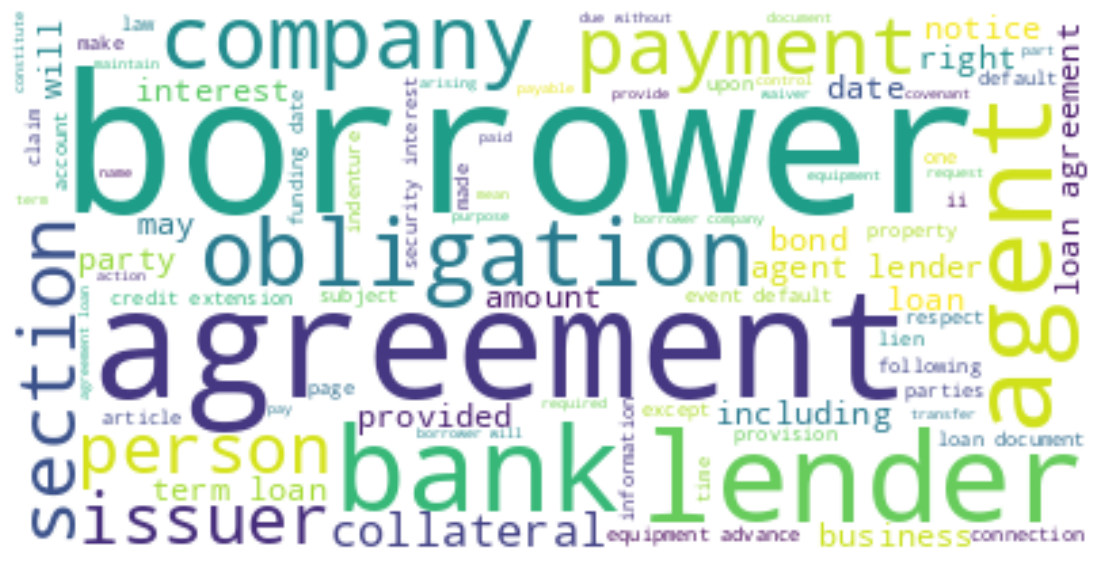

In [ ]:
fig = plt.figure(figsize=(14, 18))

# display the word cloud
plt.imshow(sec_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In the first 10000 words, the most common ones in the text are: **Agreement**, **Borrower**, **Lender**, **Agent** and **Bank**.

## Exploratory Language Statistics

The *N-gram analysis* is useful to extract meaningful information about language usage, identify key phrases and gain insights into the structure of textual data.

In [ ]:
from collections import Counter

word_counts = Counter(text)

freqs = list(word_counts.values())

bigram_tokens = ['--'.join(pair) for pair in zip(text[:-1], text[1:])]
bigram_vocab = Counter(bigram_tokens)
bigram_freqs = list(bigram_vocab.values())

trigram_tokens = ['--'.join(triple) for triple in zip(text[:-2], text[1:-1], text[2:])]
trigram_vocab = Counter(trigram_tokens)
trigram_freqs = list(trigram_vocab.values())

freqs.sort(reverse = True)
bigram_freqs.sort(reverse = True)
trigram_freqs.sort(reverse = True)

The code above performs n-gram analysis, calculating the frequencies of individual words (*unigrams*), adjacent word pairs (*bigrams*) and consecutive word triplets (*trigrams*). It utilizes *Counter* from the *collections* module to count the occurrences of each n-gram in the text. The resulting frequency distributions are sorted in descending order to facilitate a rapid understanding of the distributions of the computed n-grams.

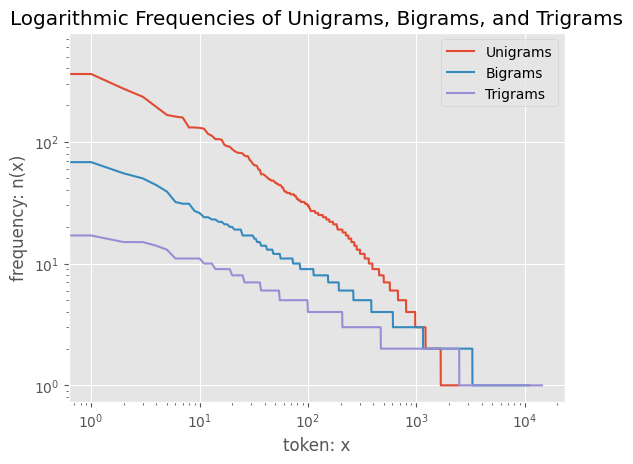

In [ ]:
plt.plot(freqs, label='Unigrams', drawstyle='default')
plt.plot(bigram_freqs, label='Bigrams', drawstyle='default')
plt.plot(trigram_freqs, label='Trigrams', drawstyle='default')

plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.legend()
plt.title('Logarithmic Frequencies of Unigrams, Bigrams, and Trigrams')
plt.xscale('log')
plt.yscale('log')

plt.show()


The logarithmic scale is employed in the plot to accommodate the wide range of frequencies, making it easier to visualize variations across different magnitudes.
\
Observe that the unigrams exhibit a more pronounced decay compared to bigrams and trigrams, as the more frequent ones have significantly higher frequencies, while the less frequent ones are fewer in number.

## LDA

After detecting five *docstart* tokens, which are assumed to mark the boundaries between distinct documents within the whole corpus, a reasonable approach consists in applying the topic modelling technique, which allows to efficiently analyze large volumes of text by clustering documents into topics.

Specifically, LDA (Latent Dirichlet Allocation) is the method used here and it is built on the assumption that documents with similar topics use similar groups of words. Then, documents can be intended as probability distributions over latent topics, which can be found by looking for group of words, and topics themselves as probability distributions on words. It is also important to notice that the order of the words and the grammatical role of the words (subjects, objects, verbs, etc.) are not considered in the model.

Before proceeding with topic modelling, it is advisable to apply the lemmatization technique which aims to reduce the word into a common base word or root word, then facilitating grouping similar words.

Using the *Spacy* module, the Spacy pipeline is applied to **doc**, which contains the cleaned text.

In [ ]:
nlp = spacy.load('en_core_web_sm')

lemm_doc = nlp(doc)

The lemmatized version of the document is then generated, and the 24th token along with its lemma is printed, as an example.

In [ ]:
lemm_text = []
for token in lemm_doc:
  lemm_text.append(token.lemma_)

print(lemm_doc[23])
print(lemm_text[23])

located
locate


Indices are identified in the text where the token *docstart* is present, indicating a potential starting point for distinct documents. The text is then partitioned into five segments, likely representing separate sections. The *NLTK* library is then applied to process words, and the resulting data is organized into a *Pandas* dataframe.

In [ ]:
for i in range(len(lemm_text)):
  if lemm_text[i] == 'docstart':
    print(i)

3596
4889
7992
15931


In [ ]:
lemm_d1 = lemm_text[0:3596]
lemm_d2 = lemm_text[3597:4889]
lemm_d3 = lemm_text[4890:7992]
lemm_d4 = lemm_text[7993:15931]
lemm_d5 = lemm_text[15932:]
lemm_docs = [lemm_d1, lemm_d2, lemm_d3, lemm_d4, lemm_d5]

In [ ]:
%%capture
import numpy as np
import nltk
import re

nltk.download('stopwords')

In [ ]:
lemm_data = [' '.join(word for word in sent) for sent in lemm_docs]
lemm_data_df = pd.DataFrame(lemm_data, columns = ['Documents'])

lemm_data_df

,Documents
0,loan security agreement date january silicon v...
1,date march thinkplus investment limited lender...
2,loan agreement loan agreement date september e...
3,loan security agreement loan security agreemen...
4,loan agreement loan agreement agreement make e...


*CountVectorizer* from *scikit-learn* module is used to convert textual data into a structured Document-Term Matrix (DTM). This matrix represents the frequency of terms in the given documents: parameters like *max_df* and *min_df* are employed to filter out terms based on their occurrence frequency in the documents, and English stopwords are excluded.
The resulting DTM is then organized into a *Pandas* dataframe.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df = 0.8, min_df = 0.1, stop_words = 'english')

In [ ]:
lemm_dtm = cv.fit_transform(lemm_data_df['Documents'])
lemm_dtm_df = pd.DataFrame(lemm_dtm.toarray(), columns = cv.get_feature_names_out())

After several attempts in finding the right number of topics, the LDA model is executed with 3 topics and a specified random state for reproducibility; then it is fitted to the Document-Term Matrix, and retrieves the topic-term distributions.


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as lda

LDA = lda(n_components = 3, random_state = 22)
LDA.fit(lemm_dtm)

LatentDirichletAllocation(n_components=3, random_state=22)

In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['financial', 'certificate', 'deposit', 'property', 'lien', 'extension', 'permit', 'section', 'subsidiary', 'credit', 'event', 'collateral', 'agent', 'lender', 'borrower']


THE TOP 15 WORDS FOR TOPIC #1
['accrue', 'refer', 'china', 'airland', 'usd', 'shanghai', 'sign', 'share', 'funding', 'tranche', 'fax', 'address', 'mean', 'article', 'borrower']


THE TOP 15 WORDS FOR TOPIC #2
['terminal', 'project', 'lease', 'fee', 'coal', 'page', 'trustee', 'expense', 'indenture', 'advance', 'bond', 'section', 'equipment', 'issuer', 'bank']




Exploring the topics derived from the data using LDA model and analyzing the 15 most frequent words within each topic, 3 distinctive themes can be discerned. The first topic delves into financial agreements and lending, as suggested by terms like *certificate*, *lender*, and *borrower*. The second one focuses on international business and funding, indicating a global financial perspective and possible agreements between USA and China, since there are terms like *usd*, *shangai*, *share* and *tranche*. In the end, the last topic centers around financial and legal contracts, encompassing words like *trustee*, *lease* and *bond*, suggesting contractual aspects in large-scale projects.
\
Through this analysis it is gained a nuanced understanding of the diverse subjects encapsulated within the different topics.

The *transform* method, using the pre-trained LDA model, gives another matrix containing the topics' probability distributions for each document. Each row corresponds to a document and each column corresponds to a topic. A new `Topic` column is added to the dataframe, where each entry denotes the dominant topic for the respective document, determined by finding the index with the highest probability in the transformed matrix.

\
Consequently, *pyLDAvis* extracts insights from a fitted LDA topic model, providing a user-friendly and interactive web-based visualization. By clarifying topics extracted from textual data, *pyLDAvis* enables a dynamic and intuitive exploration of the underlying structures uncovered during the topic modeling process.

In [ ]:
lemm_topic_results = LDA.transform(lemm_dtm)
lemm_data_df['Topic'] = lemm_topic_results.argmax(axis = 1)
lemm_data_df

,Documents,Topic
0,loan security agreement date january silicon v...,0
1,date march thinkplus investment limited lender...,1
2,loan agreement loan agreement date september e...,2
3,loan security agreement loan security agreemen...,0
4,loan agreement loan agreement agreement make e...,0


In [ ]:
from IPython.display import HTML

HTML(filename='/content/drive/MyDrive/lda_visualization.html')

Using the *prepare* method of *pyLDAvis.lda_model* library, the interactive graph above is obtained.

This visualization includes: a scatter plot where each point represents a topic, the distance between points indicates the similarity between topics the size of the points represents the prevalence of topics in the corpus; a bar chart on the side displaying the 30 most relevant terms for the selected topic, in which the light-blue part corresponds to the overall frequency of each term, while the red part is the estimated term frequency within the selected topic, indicating the relative prevalence of a specific term within the chosen topic.

It is possible to choose both the preferred topic and the values of lambda from the respective dropdown lists.
The lambda parameter in this context is related to the interactivity of the visualization: it controls the relevance of terms displayed in the visualization.
\
Values of lambda very close to 0 will show terms that are more specific for a chosen topic, so terms that are "important" for that specific topic but not necessarily "important" for the whole corpus will be seen.
\
Values of lambda close to 1 will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus.
\
So, changing the value of lambda will influence how terms are ranked and displayed in the visualization. It allows to explore topics with different emphases on term relevance.

## Sentiment Analysis

Sentiment Analysis seeks to discern and extract opinions embedded within a given text. Its goal is to measure the attitude, sentiments, evaluations and emotions expressed by a speaker or writer through computational analysis of subjectivity in the text.
\
**VADER** (Valence Aware Dictionary for sEntiment Reasoning) is a model, accessible in the *NLTK* package, used for sentiment analysis and it considers both the polarity (positive/negative) and intensity (strength) of emotions;
VADER sentiment analysis operates based on a dictionary that correlates lexical features to emotion intensities, known as sentiment scores. To derive the sentiment score of a given text, one can obtain it by summing up the intensity associated with each word in the text.

In [ ]:
%%capture
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
df_sent = lemm_data_df[['Documents']]
df_sent['scores'] = df_sent['Documents'].apply(lambda Documents: sid.polarity_scores(Documents))
df_sent['compound']  = df_sent['scores'].apply(lambda score_dict: score_dict['compound'])
df_sent['comp_score'] = df_sent['compound'].apply(lambda c: 'positive' if c >=0 else 'negative')
df_sent

,Documents,scores,compound,comp_score
0,loan security agreement date january silicon v...,"{'neg': 0.068, 'neu': 0.718, 'pos': 0.215, 'co...",1.0000,positive
1,date march thinkplus investment limited lender...,"{'neg': 0.033, 'neu': 0.69, 'pos': 0.277, 'com...",0.9999,positive
2,loan agreement loan agreement date september e...,"{'neg': 0.065, 'neu': 0.756, 'pos': 0.178, 'co...",0.9999,positive
3,loan security agreement loan security agreemen...,"{'neg': 0.043, 'neu': 0.735, 'pos': 0.222, 'co...",1.0000,positive
4,loan agreement loan agreement agreement make e...,"{'neg': 0.042, 'neu': 0.628, 'pos': 0.331, 'co...",1.0000,positive


A new table **df_sent** has been created, containing for each of the five documents, the scores of the sentiment analysis, especially highlighting the compound score (computed by normalizing the other scores: negative, neutral and positive): all the compound scores of the five documents are basically one, suggesting uniformly strong positive sentiment. These results suggest that the analyzed document were drafted for regulation, not for sanctioning potential financial misconduct.


## Interactive Dashboard

*Dash*, a python framework created by *plotly*, can be used to present data in a visual way, using an interactive dashboard.
\
Two different interactive dashboards will be presented.

In [ ]:
%%capture
!pip install dash

In [ ]:
import dash
import plotly.express as px
from dash import dcc, html
from dash.dependencies import Input, Output

In [ ]:
norm_df.loc[0:3596, 'Document']=1
norm_df.loc[3597:4889, 'Document']=2
norm_df.loc[4890:7992, 'Document']=3
norm_df.loc[7993:15931, 'Document']=4
norm_df.loc[15932:, 'Document']=5
norm_df['Document'] = norm_df['Document'].astype(int)

In [ ]:
df_no_O = norm_df.loc[norm_df['ner_tags'] != 'O']

In [ ]:
color_mapping = {
    'I-PER': 'blue',
    'I-LOC': 'green',
    'I-ORG': 'orange',
    'I-MISC': 'purple'
}

app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Dropdown(
        id='document-dropdown',
        options=[{'label': str(doc), 'value': doc} for doc in df_no_O['Document'].unique()],
        value=df_no_O['Document'].min(),
        style={'width': '50%'}
    ),

    dcc.Graph(id='ner-tags-bar-chart'),
])

@app.callback(
    Output('ner-tags-bar-chart', 'figure'),
    [Input('document-dropdown', 'value')]
)
def update_figure(selected_document):
    filtered_df = df_no_O[df_no_O['Document'] == selected_document]

    ner_tags_counts = filtered_df['ner_tags'].value_counts()

    fig = px.bar(ner_tags_counts,
                 x=ner_tags_counts.index,
                 y=ner_tags_counts.values,
                 color=ner_tags_counts.index,
                 color_discrete_map=color_mapping,
                 labels={'x':'NER Tags', 'y':'Frequency'})

    fig.update_xaxes(title_text='NER Tags')
    fig.update_layout(legend_title_text='NER Tags')
    return fig

In [ ]:
if __name__ == '__main__':
  app.run_server(debug=True,port=8050)

<IPython.core.display.Javascript object>

The first interactive dashboard presents the absolute frequency of NER tags for each document, utilizing the normalized dataset (*df_no_O*), from which the **O** labels have been excluded due to their notably higher prevalence compared to the other four NER tags.
\
This dashboard reveals a well-balanced scenario: **I-ORG** dominates in documents 1 and 3, **I-LOC** in the second document, while **I-PER** is prominent in the last two documents. As for **I-MISC**, all seven observations are concentrated in the fifth document.

In [ ]:
lemm_data_df['Count'] = lemm_data_df['Documents'].apply(lambda x: len(x.split()))
lemm_data_df['doc'] = range(1, len(lemm_data_df) + 1)
lemm_data_df['doc'] = lemm_data_df['doc'].astype(str)

In [ ]:
app2 = dash.Dash(__name__)

color_mapping2 = {
    '1': 'blue',
    '2': 'green',
    '3': 'orange',
    '4': 'purple',
    '5': 'red'
}

app2.layout = html.Div([
    dcc.Dropdown(
        id='document-dropdown',
        options=[{'label': str(doc), 'value': doc} for doc in lemm_data_df['Topic'].unique()],
        value=lemm_data_df['Topic'].min(),
        style={'width': '50%'}
    ),
    dcc.Graph(id='word-freq-bar-chart'),
])

@app2.callback(
    Output('word-freq-bar-chart', 'figure'),
    [Input('document-dropdown', 'value')]
)
def update_figure2(selected_topic):

    filtered_data = lemm_data_df[lemm_data_df['Topic'] == selected_topic]


    fig2 = px.bar(filtered_data,
                 x='doc',
                 y='Count',
                 color='doc',
                 color_discrete_map=color_mapping2,
                 labels={'x':'doc', 'y':'Words Count'})

    fig2.update_xaxes(title_text='Documents')
    fig2.update_yaxes(title_text='Words Count')
    fig2.update_layout(legend_title_text='Documents')

    return fig2

In [ ]:
if __name__ == '__main__':
  app2.run_server(debug=True,port=8051)

<IPython.core.display.Javascript object>

The second interactive dashboard illustrates the word count distribution for each document across the three topics.
\
In particular, topic 1 comprises words exclusively from the second document, while topic 2 solely encompasses words from the third document. Conversely, topic 0 is distributed across the remaining three documents, with the fourth document being notably longer compared to the others.


# Neural Network

The operations of data preparation and cleaning performed above, are repeated on the test dataset *FIN3.csv*.

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/FIN3.csv', sep = ';')
df_test.columns = ['id', 'chunk_label', 'empty', 'ner_tags']
df_test = df_test.drop(0)
df_test = df_test.dropna()
df_test.index = range(1, 11673)
df_test.drop("empty", axis = 'columns', inplace = True)
df_test['id'] = df_test['id'].map(str.lower)

removed = []

for index, id, chunk_label, ner_tags in df_test.itertuples():
  if id.isalnum() == False or id.isalpha() == False or id in stopwords or len(id) < 2:
    removed.append(index)

norm_df_test = df_test.drop(removed)
norm_df_test.index = range(1, 4906)

## Token Ordinal Encoding (1 feature)



In [ ]:
%%capture
!pip install seqeval

In [ ]:
import urllib
import sklearn
import logging
import os
import numpy as np
from seqeval.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

The training and validation datasets are created from **norm_df** using the *train_test_split* function.
Specifically, the function splits the **norm_df** dataframe into feature (`id`) and target variable (`ner_tags`) for both the training (*raw_train*, *ner_train*) and validation (*raw_valid, ner_valid*) sets. The proportion of data allocated to the validation set is 20% (set by the *test_size* parameter).

The test is split in the same way into *raw_test* and *ner_test*.

Finally labels used in the Named Entity Recognition task are saved into a set.

In [ ]:
raw_train, raw_valid, ner_train, ner_valid = train_test_split(norm_df['id'], norm_df['ner_tags'],
                                                              test_size = 0.2, random_state = 22)
raw_test = norm_df_test['id']
ner_test = norm_df_test['ner_tags']

ner_labels = set()
ner_labels.add('I-MISC')
ner_labels.add('I-PER')
ner_labels.add('I-LOC')
ner_labels.add('I-ORG')
ner_labels.add('O')

In [ ]:
ner_labels

{'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

Firstly *raw_train*, *raw_valid* and *raw_test* are converted into lists. These lists are processed using the *Tokenizer*, which maps the tokens to sequences of numerical indices. The mapping of each tag to a unique numerical index is saved in *tag2idx* dictionary and the reverse mapping is saved in *idx2tag* dictionary.
\
The NER tags in the training, validation and test sets are afterwards converted into numerical sequences using the previous mappings. This step is needed for representing categorical labels in a format suitable for training machine learning models.

In [ ]:
raw_train = raw_train.tolist()
raw_valid = raw_valid.tolist()
raw_test = raw_test.tolist()

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(raw_train + raw_valid + raw_test)

train_sequences = tok.texts_to_sequences(raw_train)
valid_sequences = tok.texts_to_sequences(raw_valid)
test_sequences = tok.texts_to_sequences(raw_test)

tag2idx = {tag: idx for idx, tag in enumerate(ner_labels)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

ner_train_sequences = [tag2idx[tag] for tag in ner_train]
ner_valid_sequences = [tag2idx[tag] for tag in ner_valid]
ner_test_sequences = [tag2idx[tag] for tag in ner_test]

The NER tag sequences are one-hot encoded using the *to_categorical* function from *Keras*, representing each tag as a binary vector.

The input features *train_sequences*, *valid_sequences* and *test_sequences* are then converted to *NumPy* arrays.

Finally, the target variables *y_train*, *y_valid*, *y_test* are also converted to *NumPy* arrays, ensuring that also target labels are in a format suitable for training and evaluation in a machine learning model.

In [ ]:
y_train = to_categorical(ner_train_sequences, num_classes = len(ner_labels), dtype = 'int32')
y_valid = to_categorical(ner_valid_sequences, num_classes = len(ner_labels), dtype = 'int32')
y_test = to_categorical(ner_test_sequences, num_classes = len(ner_labels), dtype = 'int32')

In [ ]:
X_train = np.array(train_sequences)
X_valid = np.array(valid_sequences)
X_test = np.array(test_sequences)
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

## Model (1 feature)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
import re
import os

A *GloVe* pre-trained word embeddings is now loaded from the *glove.6B.100d.txt.word2vec* file in the *embedding_index* dictionary, where each word is associated with its corresponding vector representation.

*GloVe* embeddings are often pre-trained on large corpora, capturing general language patterns, therefore the model benefits from knowledge gained on a broader dataset, enhancing its ability to generalize even with a limited training data.

In [ ]:
embeddings_index = {}
f = open(os.path.join('/content/drive/MyDrive/', 'glove.6B.100d.txt.word2vec'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [ ]:
word_index = tok.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2845 unique tokens.


The embedding matrix is now prepared for the neural network model.
For each word in the *Tokenizer*, the corresponding vector in the pre-trained *GloVe* embeddings is added to to the embedding matrix, if the word is found; otherwise, a random vector is assigned. The resulting matrix serves as the initial embedding layer for the neural network.

In [ ]:
max_features = 10000
num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in our tokenizer lets try to find that word in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

2846


The neural network model is defined as follows.

It incorporates an Embedding layer initialized with pre-trained *GloVe* embeddings, followed by bidirectional and unidirectional *LSTM* layers. The model includes a Dense layer with *ReLU* activation and a final Dense layer with *Softmax* activation for multi-class classification, giving the probability of the token being in a specific class. The model is compiled using *Categorical crossentropy* loss and the *Adam* optimizer.

In [ ]:
# Set the number of LSTM output units
lstm_out = 200

# Create a Sequential model
model = Sequential()

# Add an Embedding layer with pre-trained GloVe embeddings
model.add(Embedding(num_words, embedding_dim,
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length=X_train.shape[1]))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(lstm_out, return_sequences = True)))

# Add a unidirectional LSTM layer
model.add(LSTM(lstm_out))

# Add a Dense layer with ReLU activation
model.add(Dense(lstm_out, activation = 'relu'))

# Add the output Dense layer with softmax activation
model.add(Dense(5, activation = 'softmax'))

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 100)            284600    
                                                                 
 bidirectional (Bidirection  (None, 1, 400)            481600    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 200)               480800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 1288205 (4.91 MB)
Trainable params: 1288205 (4.91 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Visual representation of the neural network:


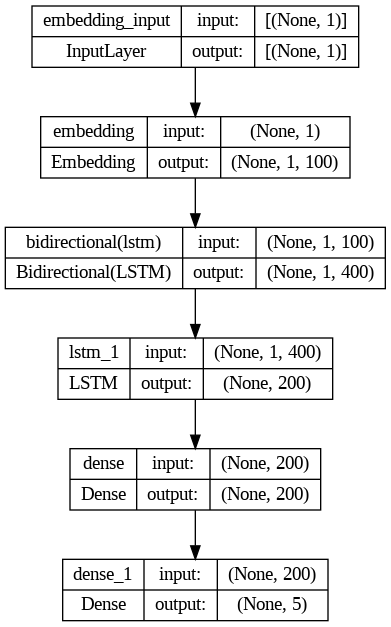

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# The model training is stopped when the validation loss remains equal for 4 successive epochs
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights = True)

The neural network model is trained on the training data for 50 epochs with a batch size of 64. Validation data is used for model evaluation during training and early stopping is applied to prevent overfitting.

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs=50, batch_size = batch_size, verbose = 1,
                    validation_data = (X_valid, y_valid), callbacks = [early_stopping])

Epoch 1/50
224/224 [==============================] - 30s 45ms/step - loss: 0.1806 - accuracy: 0.9606 - val_loss: 0.0786 - val_accuracy: 0.9768
Epoch 2/50
224/224 [==============================] - 6s 25ms/step - loss: 0.0593 - accuracy: 0.9828 - val_loss: 0.0598 - val_accuracy: 0.9818
Epoch 3/50
224/224 [==============================] - 5s 21ms/step - loss: 0.0433 - accuracy: 0.9869 - val_loss: 0.0569 - val_accuracy: 0.9832
Epoch 4/50
224/224 [==============================] - 3s 13ms/step - loss: 0.0362 - accuracy: 0.9885 - val_loss: 0.0609 - val_accuracy: 0.9813
Epoch 5/50
224/224 [==============================] - 3s 14ms/step - loss: 0.0315 - accuracy: 0.9897 - val_loss: 0.0585 - val_accuracy: 0.9846
Epoch 6/50
224/224 [==============================] - 5s 21ms/step - loss: 0.0295 - accuracy: 0.9894 - val_loss: 0.0666 - val_accuracy: 0.9816
Epoch 7/50
224/224 [==============================] - 4s 16ms/step - loss: 0.0281 - accuracy: 0.9902 - val_loss: 0.0696 - val_accuracy: 0.981

NER tags are now predicted on the *X_test* using the previously trained model.
Predictions and their corresponding true values are displayed.

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

for idx in range(len(X_test)):
    word_idx = int(X_test[idx])
    true_tag = idx2tag[y_true[idx]]
    pred_tag = idx2tag[y_pred[idx]]

    print(f'{tok.index_word[word_idx]:15}  {true_tag:6} | {pred_tag}')

154/154 [==============================] - 3s 6ms/step
subordinated     O      | O
loan             O      | O
agreement        O      | O
silicium         I-ORG  | O
de               I-ORG  | O
provence         I-ORG  | I-LOC
sas              I-ORG  | I-ORG
evergreen        I-ORG  | O
solar            I-ORG  | O
inc              I-ORG  | O
december         O      | O
herbert          I-PER  | I-PER
smith            I-PER  | O
logo             O      | O
silicium         I-ORG  | O
de               I-ORG  | O
provence         I-ORG  | I-LOC
sas              I-ORG  | I-ORG
evergreen        I-ORG  | O
solar            I-ORG  | O
inc              O      | O
subordinated     O      | O
loan             O      | O
agreement        O      | O
herbert          I-PER  | I-PER
smith            I-PER  | O
llp              O      | I-ORG
page             O      | O
december         O      | O
table            O      | O
contents         O      | O
clause           O      | O
headings         O   

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Acc')
    plt.plot(x, val_acc, 'r', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

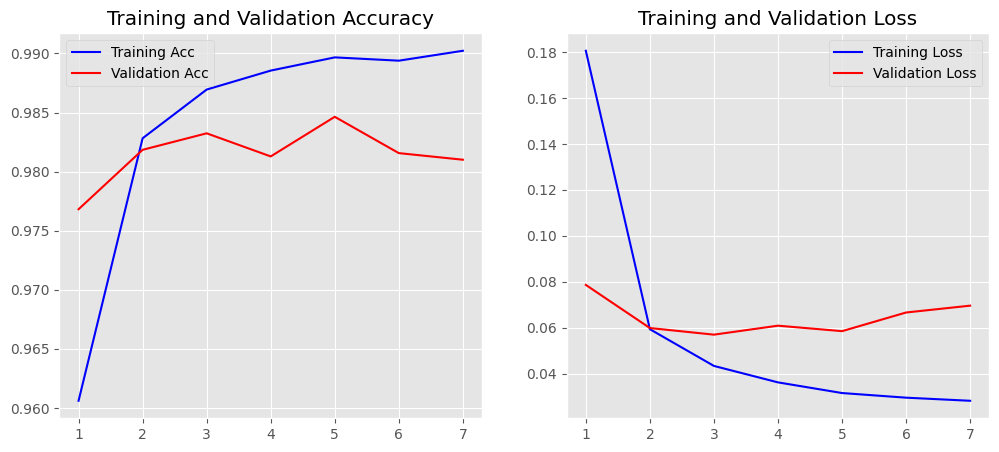

In [ ]:
plot_history(history)

The previous graph represents the behaviour of the Accuracy and the Loss of both the training and validation set at every epoch.
\
The training accuracy reaches approximately 0.99 and the training loss drops to less than 0.03. The validation accuracy reaches approximately 0.985, affirming the model's effective generalization to unseen data.
\
Furthermore the validation loss remains low at around 0.07, indicating robust generalization capabilities without overfitting.
\
Overall, these results suggest that the model has demonstrated good performance in both the training and validation phases.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4548
           1       0.50      0.70      0.59        61
           2       0.98      0.89      0.93       192
           3       0.00      0.00      0.00         7
           4       0.37      0.33      0.35        97

    accuracy                           0.96      4905
   macro avg       0.57      0.58      0.57      4905
weighted avg       0.96      0.96      0.96      4905



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



The classification report reveals an overall model accuracy of 96%, which surpasses the ratio between **O** tags and the entire set of NER tags. This is particularly noteworthy as **O** tags constitute 92% of all observations, a significantly high proportion. It indicates that the model performs better than one that simply predicts **O** tags. In essence, the model successfully distinguishes between entities of interest and others, outperforming a model reliant on **O** predictions that would be primarily influenced by the prevalence of that class.
\
In the minority classes (**I-LOC** and **I-ORG**) the precision is low, suggesting a greater difficulty in correctly identifying instances in this category.
The recall, representing the model's ability to correctly identify all positive instances, shows varying results across classes, indicating potential areas for improvement. Overall, the weighted average of F1-scores is equal to 96% and reflects a good balance of precision and recall across all considered classes.

Considering that the dataset is unbalanced, with the **O** class having significantly bigger instances, giving priority to the F1 score becomes crucial. Indeed, the F1 score, being the armonic mean of precision and recall, provides a more comprehensive evaluation.



In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
def plot_confusion_matrix(y_preds, y_test, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

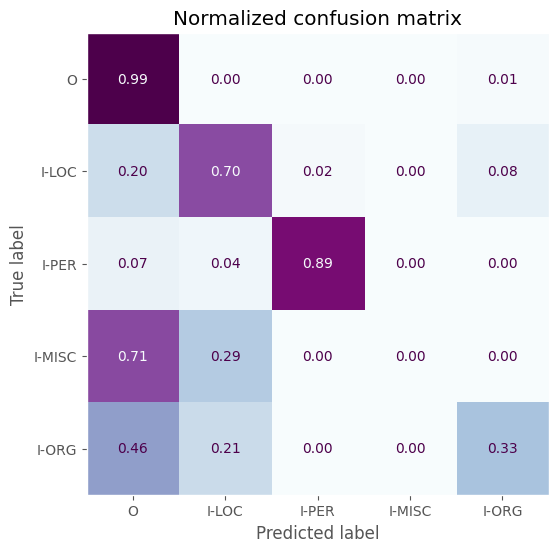

In [ ]:
plot_confusion_matrix(y_pred, y_true, ner_labels)

The normalized confusion matrix provides valuable insights into the model's performance across different NER tags. Each row of the matrix corresponds to the true class, while each column represents the predicted class. The color intensity in each cell reflects the recall, which is the proportion of true positive predictions relative to the total true instances for that class.
\
Strong diagonal elements can be observed, especially for the **O** and the **I-PER** NER tags, indicating high correctness in predictions for these categories. However, off-diagonal elements reveal areas where the model encounters challenges.

## Token Ordinal Encoding (2 features)

It is now introduced a new model that extends beyond the use of only word identifiers `id` and incorporates an additional feature `chunk_labels`.
The addition of this new variable aims to enrich the informational context available to the model, with the goal of achieving more accurate predictions.
\
The dataset preparation for the validation, training and test phases mirrors the procedures undertaken previously.
The dataset is again divided into features and target variable, encompassing both `id` and `chunk_label` features. The categorical encoding of `chunk_label` is computed as before. Subsequently, the resulting sequences and chunk labels are organized to construct input arrays for each dataset split (*training*, *validation*, and *test*).

In [ ]:
%%capture

raw_train_2, raw_valid_2, ner_train_2, ner_valid_2 = train_test_split(norm_df[['id','chunk_label']], norm_df['ner_tags'],
                                                              test_size = 0.2, random_state = 22)
raw_test_2 = norm_df_test[['id','chunk_label']]
ner_test_2 = norm_df_test['ner_tags']

raw_train_2['chunk_label'] = raw_train_2['chunk_label'].astype('category').cat.codes
raw_valid_2['chunk_label'] = raw_valid_2['chunk_label'].astype('category').cat.codes
raw_test_2['chunk_label'] = raw_test_2['chunk_label'].astype('category').cat.codes

chunk_train = raw_train_2['chunk_label']
chunk_valid = raw_valid_2['chunk_label']
chunk_test = raw_test_2['chunk_label']

train_sequences_2 = [numero for sublist in train_sequences for numero in sublist]
valid_sequences_2 = [numero for sublist in valid_sequences for numero in sublist]
test_sequences_2 = [numero for sublist in test_sequences for numero in sublist]

chunk_train = chunk_train.to_list()
chunk_valid = chunk_valid.to_list()
chunk_test = chunk_test.to_list()

X_train_2 = np.array([train_sequences_2, chunk_train])
X_valid_2 = np.array([valid_sequences_2, chunk_valid])
X_test_2 = np.array([test_sequences_2, chunk_test])

X_train_2 = X_train_2.T
X_valid_2 = X_valid_2.T
X_test_2 = X_test_2.T

## Model (2 features)

Similarly to the previous model, the neural network structure remains consistent (embedding layer, LSTM layers and the final dense layers). The key difference lies in the input structure, where `chunk_label` is included alongside `id` as part of the feature set. The training and evaluation processes are coherent with the previous model assessment. The introduction of `chunk_label` aims to give additional contextual information to improve the performance of NER tags recognition.

In [ ]:
lstm_out = 200

model = Sequential()
model.add(Embedding(num_words, embedding_dim,
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length=X_train_2.shape[1]))
model.add(Bidirectional(LSTM(lstm_out, return_sequences = True)))
model.add(LSTM(lstm_out))
model.add(Dense(lstm_out, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2, 100)            284600    
                                                                 
 bidirectional_1 (Bidirecti  (None, 2, 400)            481600    
 onal)                                                           
                                                                 
 lstm_3 (LSTM)               (None, 200)               480800    
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 1288205 (4.91 MB)
Trainable params: 1288205 (4.91 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
batch_size = 64
history_2 = model.fit(X_train_2, y_train, epochs=50, batch_size = batch_size, verbose = 1,
                    validation_data = (X_valid_2, y_valid), callbacks = [early_stopping])

Epoch 1/50
224/224 [==============================] - 12s 24ms/step - loss: 0.1552 - accuracy: 0.9635 - val_loss: 0.0667 - val_accuracy: 0.9796
Epoch 2/50
224/224 [==============================] - 3s 11ms/step - loss: 0.0523 - accuracy: 0.9846 - val_loss: 0.0436 - val_accuracy: 0.9869
Epoch 3/50
224/224 [==============================] - 3s 13ms/step - loss: 0.0372 - accuracy: 0.9888 - val_loss: 0.0479 - val_accuracy: 0.9869
Epoch 4/50
224/224 [==============================] - 3s 15ms/step - loss: 0.0292 - accuracy: 0.9912 - val_loss: 0.0486 - val_accuracy: 0.9860
Epoch 5/50
224/224 [==============================] - 3s 11ms/step - loss: 0.0265 - accuracy: 0.9920 - val_loss: 0.0495 - val_accuracy: 0.9872
Epoch 6/50
224/224 [==============================] - 2s 9ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.0471 - val_accuracy: 0.9880


In [ ]:
y_pred_2 = model.predict(X_test_2)
y_pred_2 = np.argmax(y_pred_2, axis=-1)
y_true_2 = np.argmax(y_test, axis=-1)

for idx in range(len(X_test)):
    word_idx = int(X_test[idx])
    true_tag_2 = idx2tag[y_true_2[idx]]
    pred_tag_2 = idx2tag[y_pred_2[idx]]

    print(f'{tok.index_word[word_idx]:15}  {true_tag_2:6} | {pred_tag_2}')

154/154 [==============================] - 2s 3ms/step
subordinated     O      | O
loan             O      | O
agreement        O      | O
silicium         I-ORG  | O
de               I-ORG  | O
provence         I-ORG  | O
sas              I-ORG  | I-ORG
evergreen        I-ORG  | I-ORG
solar            I-ORG  | O
inc              I-ORG  | O
december         O      | O
herbert          I-PER  | I-PER
smith            I-PER  | O
logo             O      | O
silicium         I-ORG  | O
de               I-ORG  | O
provence         I-ORG  | O
sas              I-ORG  | I-ORG
evergreen        I-ORG  | I-ORG
solar            I-ORG  | O
inc              O      | O
subordinated     O      | O
loan             O      | O
agreement        O      | O
herbert          I-PER  | I-PER
smith            I-PER  | O
llp              O      | I-ORG
page             O      | O
december         O      | O
table            O      | O
contents         O      | O
clause           O      | O
headings         O   

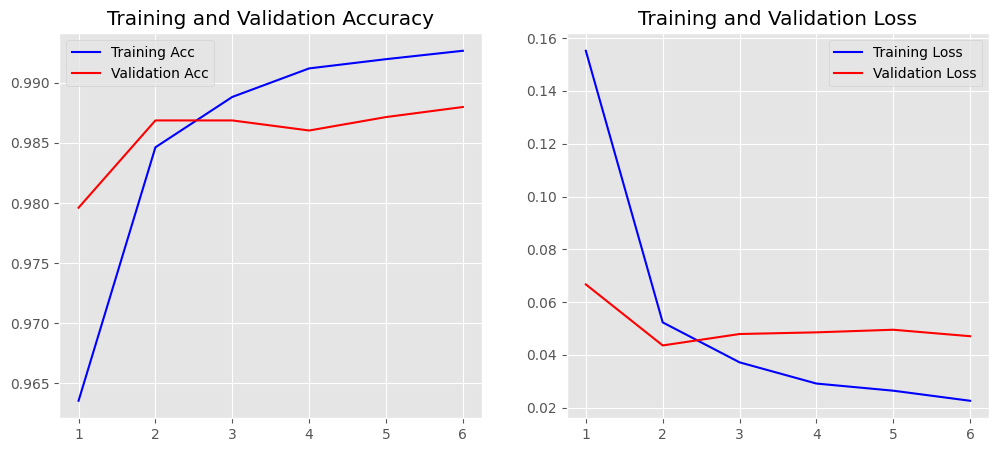

In [ ]:
plot_history(history_2)

With a training accuracy reaching around 99% and a corresponding training loss reaching 0.02, the model exhibits robust learning. This success extends to the validation phase, where an accuracy of about 98.5% is achieved, confirming the model's ability to generalize effectively. The associated validation loss of approximately 0.05 further underscores the model's stable performance, indicating reliable generalization without overfitting. These findings affirm the model's consistent and reliable behavior across both training and validation stages.

In [ ]:
print(classification_report(y_true_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4548
           1       0.42      0.56      0.48        61
           2       0.97      0.90      0.93       192
           3       0.00      0.00      0.00         7
           4       0.42      0.34      0.38        97

    accuracy                           0.96      4905
   macro avg       0.56      0.56      0.55      4905
weighted avg       0.96      0.96      0.96      4905



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Examining the classification report, the model delivers notable performance, particularly in classifying the **O** NER tag. For the minority classes (**I-PER**, **I-LOC**, **I-ORG**), the precision and recall values vary, indicating a nuanced performance. Specifically, **I-PER** exhibits the highest precision, while **I-ORG** presents lower precision and recall values.

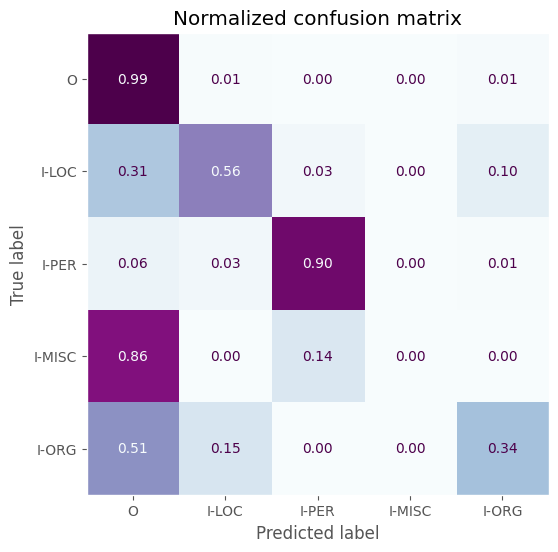

In [ ]:
plot_confusion_matrix(y_pred_2, y_true_2, ner_labels)

From the matrix strong diagonal elements can be observed, especially for the **O** and the **I-PER** NER tags, indicating high correctness in predictions for these categories. However, off-diagonal elements reveal still areas where the model encounters challenges.

## Token Ordinal Econding (NO I-MISC)

In this variant of the model, a new strategy is employed to address the limited instances of the **I-MISC** NER tag, which appears only seven times in the dataset. Since neither of the two preceding models made any predictions for **I-MISC**, in the current model these instances are reclassified as **O**. The objective is to identify potential improvements in overall classification accuracy.

The operations of splitting the dataset into training, validation and test sets are the same as the previous models. Subsequently, the *Tokenizer* is utilized to convert the raw text data into sequences of numerical values, and one-hot encoding is employed to represent the NER tag labels. These steps align with the preprocessing steps undertaken in the previous two models, ensuring a coherent and standardized approach to data preparation.

In [ ]:
%%capture
norm_df_nomisc = norm_df[['id','ner_tags']]
norm_df_nomisc['ner_tags'][norm_df_nomisc['ner_tags'] == 'I-MISC']='O'

df_test_nomisc = norm_df_test[['id','ner_tags']]
df_test_nomisc['ner_tags'][df_test_nomisc['ner_tags'] == 'I-MISC'] = 'O'

raw_train_nomisc, raw_valid_nomisc, ner_train_nomisc, ner_valid_nomisc = train_test_split(norm_df_nomisc['id'],
                                                                                          norm_df_nomisc['ner_tags'],
                                                                                          test_size = 0.2,
                                                                                          random_state = 22)
raw_test_nomisc = df_test_nomisc['id']
ner_test_nomisc = df_test_nomisc['ner_tags']

ner_labels_nomisc = set()
ner_labels_nomisc.add('I-PER')
ner_labels_nomisc.add('I-LOC')
ner_labels_nomisc.add('I-ORG')
ner_labels_nomisc.add('O')

raw_train_nomisc = raw_train_nomisc.tolist()
raw_valid_nomisc = raw_valid_nomisc.tolist()
raw_test_nomisc = raw_test_nomisc.tolist()

tok_nomisc = Tokenizer()
tok_nomisc.fit_on_texts(raw_train_nomisc + raw_valid_nomisc + raw_test_nomisc)

train_sequences_nomisc = tok_nomisc.texts_to_sequences(raw_train_nomisc)
valid_sequences_nomisc = tok_nomisc.texts_to_sequences(raw_valid_nomisc)
test_sequences_nomisc = tok_nomisc.texts_to_sequences(raw_test_nomisc)

tag2idx = {tag: idx for idx, tag in enumerate(ner_labels_nomisc)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

ner_train_sequences_nomisc = [tag2idx[tag] for tag in ner_train_nomisc]
ner_valid_sequences_nomisc = [tag2idx[tag] for tag in ner_valid_nomisc]
ner_test_sequences_nomisc = [tag2idx[tag] for tag in ner_test_nomisc]

y_train_nomisc = to_categorical(ner_train_sequences_nomisc, num_classes = len(ner_labels_nomisc), dtype = 'int32')
y_valid_nomisc = to_categorical(ner_valid_sequences_nomisc, num_classes = len(ner_labels_nomisc), dtype = 'int32')
y_test_nomisc = to_categorical(ner_test_sequences_nomisc, num_classes = len(ner_labels_nomisc), dtype = 'int32')

X_train_nomisc = np.array(train_sequences_nomisc)
X_valid_nomisc = np.array(valid_sequences_nomisc)
X_test_nomisc = np.array(test_sequences_nomisc)
y_train_nomisc = np.array(y_train_nomisc)
y_valid_nomisc = np.array(y_valid_nomisc)
y_test_nomisc = np.array(y_test_nomisc)

In [ ]:
word_index_nomisc = tok_nomisc.word_index
print('Found %s unique tokens.' % len(word_index_nomisc))

Found 2845 unique tokens.


## Model (NO I-MISC)

The model is constructed maintaining consistency with the previous ones. The distinction lies in the configuration of the neural network, where the output layer is adjusted to accommodate four classes instead of the previous five. This modification aligns with the exclusion of the **I-MISC** category. The remaining architectural components  remain unchanged.

In [ ]:
max_features = 10000
num_words_nomisc = min(max_features, len(word_index_nomisc)) + 1
print("NO-MISC vocabulary size: ",num_words_nomisc)

embedding_dim = 100

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words_nomisc, embedding_dim))

# for each word in our tokenizer lets try to find that word in our w2v model
for word, i in word_index_nomisc.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

NO-MISC vocabulary size:  2846


In [ ]:
lstm_out = 200

model = Sequential()
model.add(Embedding(num_words_nomisc, embedding_dim,
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length=X_train_nomisc.shape[1]))
model.add(Bidirectional(LSTM(lstm_out, return_sequences = True)))
model.add(LSTM(lstm_out))
model.add(Dense(lstm_out, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 100)            284600    
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 400)            481600    
 onal)                                                           
                                                                 
 lstm_5 (LSTM)               (None, 200)               480800    
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dense_5 (Dense)             (None, 4)                 804       
                                                                 
Total params: 1288004 (4.91 MB)
Trainable params: 1288004 (4.91 MB)
Non-trainable params: 0 (0.00 Byte)
________________

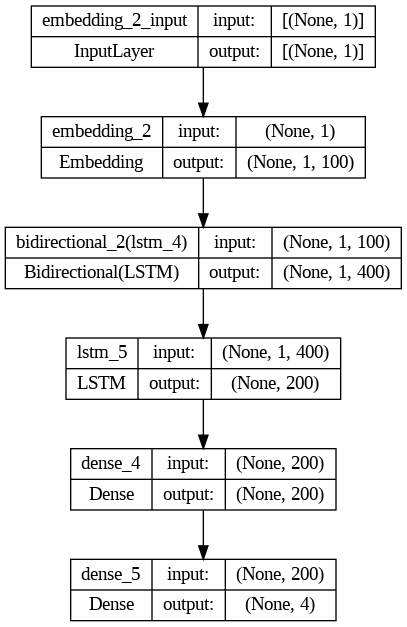

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
batch_size = 64
history_nomisc = model.fit(X_train_nomisc, y_train_nomisc, epochs=50, batch_size = batch_size, verbose = 1,
                    validation_data = (X_valid_nomisc, y_valid_nomisc), callbacks = [early_stopping])

Epoch 1/50
224/224 [==============================] - 11s 20ms/step - loss: 0.1624 - accuracy: 0.9642 - val_loss: 0.0786 - val_accuracy: 0.9799
Epoch 2/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0559 - accuracy: 0.9839 - val_loss: 0.0648 - val_accuracy: 0.9818
Epoch 3/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0417 - accuracy: 0.9869 - val_loss: 0.0611 - val_accuracy: 0.9841
Epoch 4/50
224/224 [==============================] - 3s 13ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0596 - val_accuracy: 0.9832
Epoch 5/50
224/224 [==============================] - 4s 18ms/step - loss: 0.0310 - accuracy: 0.9898 - val_loss: 0.0639 - val_accuracy: 0.9827
Epoch 6/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0297 - accuracy: 0.9896 - val_loss: 0.0703 - val_accuracy: 0.9810
Epoch 7/50
224/224 [==============================] - 2s 10ms/step - loss: 0.0270 - accuracy: 0.9899 - val_loss: 0.0670 - val_accuracy: 0.984

In [ ]:
y_pred_nomisc = model.predict(X_test_nomisc)
y_pred_nomisc = np.argmax(y_pred_nomisc, axis=-1)
y_true_nomisc = np.argmax(y_test_nomisc, axis=-1)

for idx in range(len(X_test_nomisc)):
    word_idx = int(X_test_nomisc[idx])
    true_tag_nomisc = idx2tag[y_true_nomisc[idx]]
    pred_tag_nomisc = idx2tag[y_pred_nomisc[idx]]

    print(f'{tok.index_word[word_idx]:15}  {true_tag_nomisc:6} | {pred_tag_nomisc}')

154/154 [==============================] - 1s 3ms/step
subordinated     O      | O
loan             O      | O
agreement        O      | O
silicium         I-ORG  | I-ORG
de               I-ORG  | O
provence         I-ORG  | I-LOC
sas              I-ORG  | I-ORG
evergreen        I-ORG  | O
solar            I-ORG  | O
inc              I-ORG  | O
december         O      | O
herbert          I-PER  | I-PER
smith            I-PER  | O
logo             O      | O
silicium         I-ORG  | I-ORG
de               I-ORG  | O
provence         I-ORG  | I-LOC
sas              I-ORG  | I-ORG
evergreen        I-ORG  | O
solar            I-ORG  | O
inc              O      | O
subordinated     O      | O
loan             O      | O
agreement        O      | O
herbert          I-PER  | I-PER
smith            I-PER  | O
llp              O      | O
page             O      | O
december         O      | O
table            O      | O
contents         O      | O
clause           O      | O
headings         

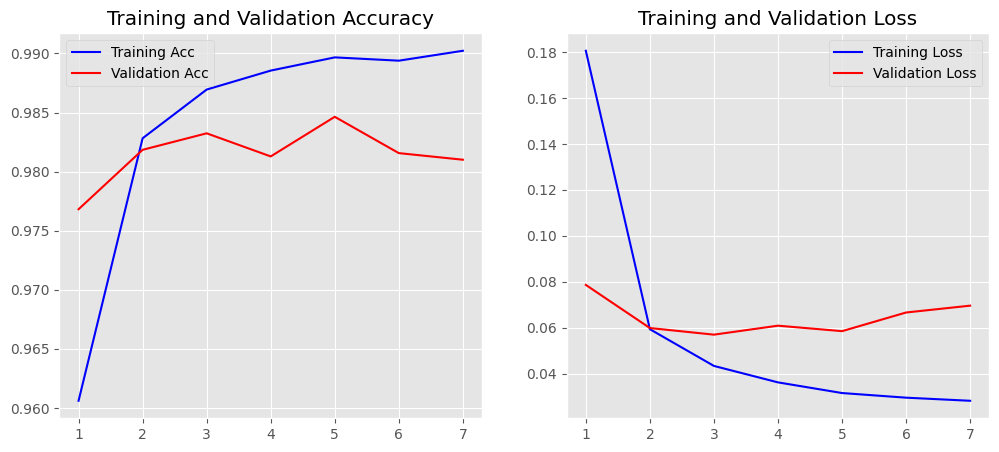

In [ ]:
plot_history(history)

The high training accuracy of about 0.99 and the low training loss of around 0.03 show that the model is learning well from the training data, making accurate predictions.
With a validation accuracy of 0.985, the model demonstrates strong generalization capabilities to new, unseen data. The validation loss remains at an acceptable level, suggesting minimal risk of overfitting.

In [ ]:
print(classification_report(y_true_nomisc, y_pred_nomisc))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4555
           1       0.54      0.62      0.58        61
           2       0.45      0.27      0.34        97
           3       0.93      0.90      0.91       192

    accuracy                           0.97      4905
   macro avg       0.72      0.70      0.70      4905
weighted avg       0.96      0.97      0.97      4905



The classification report reveals varied performance across different named entity categories. It provides an overall accuracy of the model of 97%. The model excels in predicting **O** and **I-PER** entities, with a high precision, recall, and F1-score.


In [ ]:
cf_matrix = confusion_matrix(y_true_nomisc, y_pred_nomisc, normalize = "true")

In [ ]:
def plot_confusion_matrix_nomisc(y_preds, y_test):
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=ner_labels_nomisc)
    disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

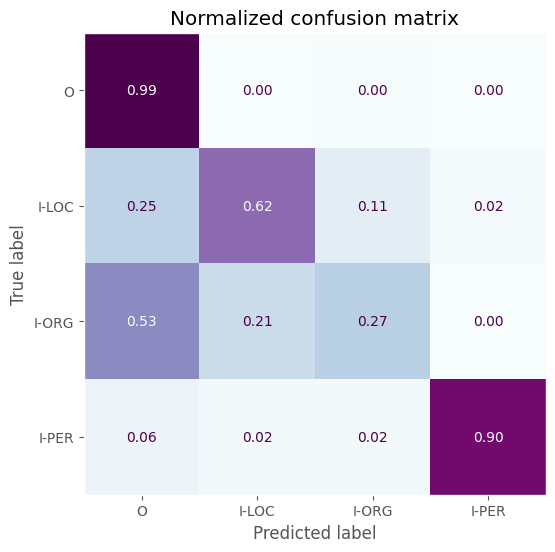

In [ ]:
plot_confusion_matrix_nomisc(y_pred_nomisc, y_true_nomisc)

From the matrix strong diagonal elements can be observed, especially for the **O** and **I-PER**, suggesting that the model performance in identifying **O** and **I-PER** NER tags is robust.
\
However, the performance is less pronounced for **I-ORG** and **I-LOC**, as indicated from off-diagonal elements.

# BERT

BERT (Bidirectional Encoder Representations from Transformers) model incorporates a bidirectional attention mechanism, allowing it to consider context from both left and right directions in a sequence, deviating from sequential models.

## Load data

The response variable in the training, validation and test is transformed from a vector to an integer. This conversion, achieved through the *argmax* function, establishes a numerical representation for the categories of the response variable in each dataset.

In [ ]:
nerid_train = np.argmax(y_train, axis = 1)
nerid_valid = np.argmax(y_valid, axis = 1)
nerid_test = np.argmax(y_test, axis = 1)

It is now created *DatasetDict* structured to contain three key elements: *train*, *validation*, and *test*. Each of these elements holds a dataset as text and corresponding indices. This organization facilitates the subsequent model training phase, allowing easy access to the required datasets during the training process.

In [ ]:
%%capture
!pip install datasets
from datasets import Dataset, DatasetDict

In [ ]:
train_dataset = Dataset.from_dict({"text": raw_train, "label": nerid_train})
validation_dataset = Dataset.from_dict({"text": raw_valid, "label": nerid_valid})
test_dataset = Dataset.from_dict({"text": raw_test, "label": nerid_test})

data_dict = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})
data_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14319
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3580
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4905
    })
})

The chosen model checkpoint, *distilbert-base-uncased*, is loaded using the *Hugging Face Transformers* library. It represents a distilled version of the *BERT* model, tailored for case-insensitive text processing tasks. The *AutoTokenizer* class is utilized to automatically select and load the appropriate tokenizer for this model checkpoint, ensuring compatibility with its architecture.

The function *tokenize* is applied to the entire dataset. This function uses the loaded tokenizer to process batches of text data, implementing padding, truncation and the addition of special tokens as needed. This preprocessing step is crucial to prepare the data for subsequent training, ensuring it aligns with the requirements of the *BERT* model.

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
def tokenize(batch):
   return tokenizer(batch["text"],padding=False, truncation=True, add_special_tokens=False)

In [ ]:
data4 = data_dict.map(tokenize, batched=True, batch_size=8)

Map:   0%|          | 0/14319 [00:00<?, ? examples/s]

Map:   0%|          | 0/3580 [00:00<?, ? examples/s]

Map:   0%|          | 0/4905 [00:00<?, ? examples/s]

## Build the Transformer

The model undergoes the process of fine-tuning for sequence classification using the *Transformers* library.

In [ ]:
import torch

The model selects the *distilbert-base-uncased* checkpoint, which serves as a robust foundation for the task at hand.

In [ ]:
%%capture
from transformers import AutoModelForSequenceClassification

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 5
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [ ]:
# To assess model's performance
# It calculates metrics like accuracy and F1 score during evaluation.
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
%%capture
#!pip install accelerate>=0.20.1

In [ ]:
# Definition of training parameters and configurations for the fine-tuning process.
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(raw_train) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

The *Trainer* module is enlisted to orchestrate the training process. The *Trainer* takes charge of managing the training loop, evaluation steps, and other essential components. The model is fine-tuned using the training dataset (*data4["train"]*), and performance is evaluated on the validation dataset (*data4["validation"]*). The process is driven by the specified training arguments, ensuring a coherent and effective fine-tuning process for the NER classification task.

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=data4["train"],
                  eval_dataset=data4["validation"],
                  tokenizer=tokenizer)

trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.144500,0.088770,0.982682,0.981251
2,0.072200,0.076248,0.984637,0.983622


Following the completion of the fine-tuning process, the model is applied to the test dataset using the *predict* method. This step involves making predictions on the test data to assess how well the model generalizes to new, unseen examples. The resulting `preds_output` contains predictions for each instance in the test dataset.

In [ ]:
preds_output = trainer.predict(data4["test"])

In [ ]:
preds_output.metrics

{'test_loss': 0.17145785689353943,
 'test_accuracy': 0.963710499490316,
 'test_f1': 0.9611230286386748,
 'test_runtime': 5.6573,
 'test_samples_per_second': 867.017,
 'test_steps_per_second': 108.532}

The test accuracy of 96.4%  has demonstrated proficiency in classifying sequences into the correct categories.
\
Additionally, the F1 score, which combines precision and recall, is computed as 96% and it suggests that the model maintains a good balance between precision and recall, achieving robust performance across multiple classes.
\
The test loss, which measures the dissimilarity between the true labels and the predicted ones, is 17%. The relatively low test loss further supports the model's effectiveness in capturing patterns and relationships within the test dataset.

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(data4["test"]["label"])

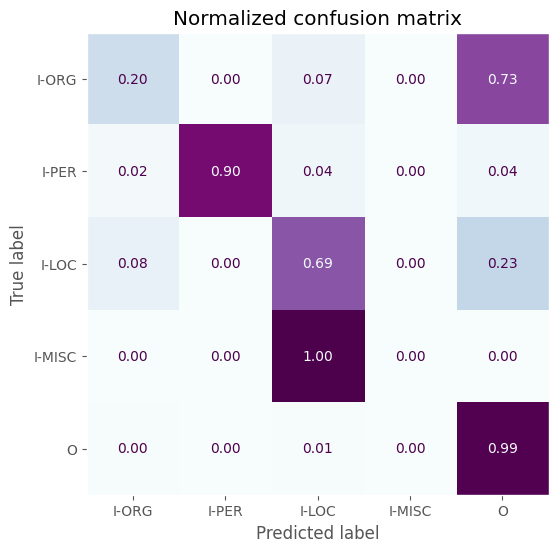

In [ ]:
plot_confusion_matrix(y_preds, y_valid, ner_labels)

From the matrix strong diagonal elements can be observed, especially for the **O** and the **I-PER** NER tags, indicating high correctness in predictions for these categories. However, off-diagonal elements reveal still areas where the model encounters challenges, particularly in the case of **I-MISC** and **I-LOC**.

# Comparison between models

The evaluation of four distinct models, each with varying configurations, reveals intriguing insights into their performance on the Named Entity Recognition (NER) task. All models consistently produce comparable accuracy, loss and F1-score results, demonstrating robust performance.
\
Despite the initial model yielding satisfactory results, the analysis of the confusion matrix revealed an oversight in predicting any instances of **I-MISC**. Subsequently, a second model was developed, incorporating `chunk_label` as an additional feature. However, although achieving excellent overall results, once again, no instances of **I-MISC** were predicted. As an improvement, the third model was devised, reclassifying **I-MISC** as **O**, resulting in a slight improvement and a minor increase in F1-score. This adjustment proved insightful in addressing the challenges posed by unbalanced datasets.
\
In addition, the BERT model demonstrated comparable accuracy, loss, and F1-score results with respect to the other models.
\
In conclusion, the consistent performance observed across diverse model architectures underscores the robustness of each approach, offering valuable insights for effectively handling unbalanced datasets.